# Dask start

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:53318")
client

<Client: 'tcp://127.0.0.1:53318' processes=4 threads=8, memory=16.00 GiB>

# Import

In [2]:
import sys
sys.path.insert(1, '..')
from pathlib import Path

In [3]:
#import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
from xhistogram.xarray import histogram
from dask import compute
import pandas as pd
import cartopy.crs as ccrs
import xgcm
from xorca.lib import load_xorca_dataset, preprocess_orca
from scipy import ndimage

In [4]:
%load_ext memory_profiler

# Plotting params

In [5]:
#%matplotlib widget
%matplotlib inline

In [6]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [7]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

# Load HR data

In [8]:
%%time
%%memit
quantity = 'votemper'
ds_test = xr.open_mfdataset('/Users/ana/data/QBOX/eNATL60QBOX3-BLB002_1h_20090710_20090714_' + quantity +'_20090714-20090714.nc', \
                            parallel=True,
                           data_vars=['votemper', 'vosaline'])

peak memory: 184.22 MiB, increment: 1.05 MiB
CPU times: user 101 ms, sys: 52.1 ms, total: 153 ms
Wall time: 707 ms


In [9]:
data_path = Path("/Users/ana/data/QBOX/")
# data_files = list(sorted(data_path.glob("eNATL60QBOX3*nc")))
data_files = [Path('/Users/ana/data/QBOX/eNATL60QBOX3-BLB002_1h_20090710_20090714_sossheig_20090714-20090714.nc'),
 Path('/Users/ana/data/QBOX/eNATL60QBOX3-BLB002_1h_20090710_20090714_vosaline_20090714-20090714.nc'),
 Path('/Users/ana/data/QBOX/eNATL60QBOX3-BLB002_1h_20090710_20090714_votemper_20090714-20090714.nc'),
 Path('/Users/ana/data/QBOX/eNATL60QBOX3-BLB002_1h_20090710_20090714_vomecrty_20090714-20090714.nc'),
 Path('/Users/ana/data/QBOX/eNATL60QBOX3-BLB002_1h_20090710_20090714_vozocrtx_20090714-20090714.nc')]
# data_files.append(data_path / "new_maskglo.nc")
aux_files = [Path('/Users/ana/data/QBOX/mask_eNATL60QBOX3.nc'),
 Path('/Users/ana/data/QBOX/mesh_hgr_eNATL60QBOX3.nc')]

In [10]:
#ds = xr.open_mfdataset(data_files,
#                       preprocess=(lambda ds:
#                                   preprocess_orca(data_path / "mesh_hgr_eNATL60QBOX3.nc", ds)))
#ds = ds.chunk({"t": 1, "z_c": 23, "z_l": 23})
#ds

In [154]:
%%time
ds = load_xorca_dataset(data_files=data_files, aux_files=aux_files,
                              decode_cf=True,
                              input_ds_chunks={"time_counter": 6, "t": 6,
                                               "z": 14, "Z": 14,
                                               "deptht": 14, "depthu": 14,
                                               "depthv": 14, "depthw": 14,
                                               "y": 245, "Y": 245,
                                               "x": 400, "X": 400},
                              target_ds_chunks={"t": 6,
                                                "z_c": 14, "z_l": 14,
                                                "y_c": 245, "y_r": 245,
                                                "x_c": 400, "x_r": 400})

CPU times: user 231 ms, sys: 6 ms, total: 237 ms
Wall time: 237 ms


In [155]:
ds = ds.drop(['somxl010', 'sossheig', 'sosaline', 'sosstsst', 'vomecrty', 'vozocrtx'])
#ds = ds[['votemper', 'vosaline']]

In [156]:
# low down the  frequency 
ds = ds.isel(t=[0,-1,6])

In [157]:
ds.coords['depth_c'] = xr.DataArray(ds_test['deptht'].values, dims='z_c')

In [158]:
ds.coords['depth_l'] = xr.DataArray(xgcm.autogenerate.generate_grid_ds(ds, {'Z':'depth_c'}).depth_c_left.values, dims='z_l')

In [159]:
print(ds.nbytes / 1e9, "GiB")

4.792297312 GiB


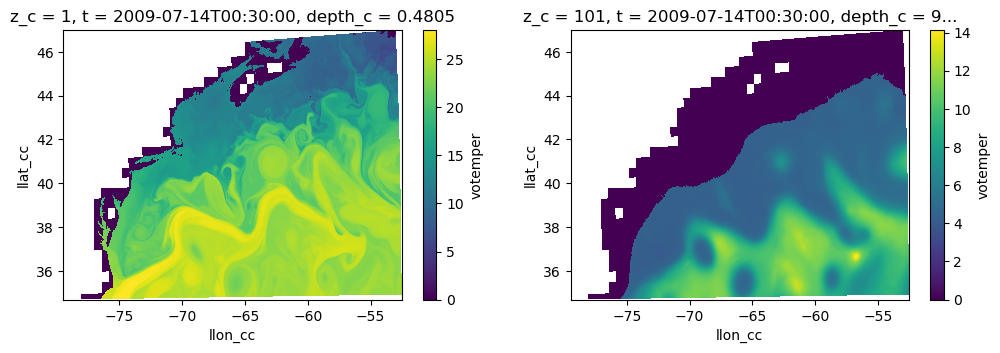

peak memory: 816.67 MiB, increment: 232.91 MiB
CPU times: user 952 ms, sys: 152 ms, total: 1.1 s
Wall time: 5.55 s


In [160]:
%%time
%%memit
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,3.5))
ds.votemper.isel(t=0, z_c=0).plot(x='llon_cc', y='llat_cc',ax=ax[0])
ds.votemper.isel(t=0, z_c=100).plot(x='llon_cc', y='llat_cc', ax=ax[1])
plt.show()

In [161]:
ds

<xarray.Dataset>
Dimensions:   (z_c: 107, z_l: 107, y_c: 976, y_r: 976, x_c: 1588, x_r: 1588,
               t: 3)
Coordinates: (12/29)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 100 101 102 103 104 105 106 107
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 103.5 104.5 105.5 106.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 969 970 971 972 973 974 975 976
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 973.5 974.5 975.5 976.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 ... 1582 1583 1584 1585 1586 1587 1588
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 ... 1.586e+03 1.588e+03 1.588e+03
    ...        ...
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(14, 245, 400), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(14, 245, 400), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(14, 245, 400), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(14, 245, 400), meta=np.ndarray>
    depth_c   (z_c) float32 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
    depth_l   (z_l) float32 -0.05871 1.02 2.177 3.491 ... 960.0 976.9 993.9
Data variables:
    vosaline  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    votemper  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>

# Grid metrics

In [162]:
ds.coords['area_t'] = ds['e1t']*ds['e2t']
ds.coords['area_u'] = ds['e1u']*ds['e2u']
ds.coords['area_v'] = ds['e1v']*ds['e2v']
ds.coords['area_f'] = ds['e1f']*ds['e2f']

In [163]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('X', 'Y',): ['area_t', 'area_u', 'area_v', 'area_f'] # Areas 
}

In [164]:
grid = xgcm.Grid(ds, metrics=metrics, periodic=False, coords={'X' : {'center' : 'x_c', 'right' : 'x_r'}, \
                                                              'Y' : {'center' : 'y_c', 'right' : 'y_r'},
                                                              'Z' : {'center' : 'z_c', 'left' : 'z_l'}})

In [165]:
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   x_c --> right
  * right    x_r --> center
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_r --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> left
  * left     z_l --> center

In [166]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = grid.diff(ds.depth_c, 'Z', boundary='fill', fill_value=np.NaN)
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = grid.diff(ds.depth_l, 'Z', boundary='fill', fill_value=np.NaN)

In [167]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['dzc', 'dzt'], # Z distances
    ('X', 'Y',): ['area_t', 'area_u', 'area_v', 'area_f'] # Areas 
}

In [169]:
grid = xgcm.Grid(ds, metrics=metrics, periodic=False, coords={'X' : {'center' : 'x_c', 'right' : 'x_r'}, \
                                                              'Y' : {'center' : 'y_c', 'right' : 'y_r'},
                                                              'Z' : {'center' : 'z_c', 'left' : 'z_l'}})

# Compute variables

Compute sea pressure

In [171]:
# NOT to forget minus in front of z
ds['pressure'] = xr.apply_ufunc(gsw.conversions.p_from_z, -ds.z_c, ds.llat_cc, dask='parallelized')

Compute density

In [172]:
ds['rho'] = xr.apply_ufunc(gsw.density.rho, ds.vosaline, ds.votemper, ds.pressure, dask='parallelized')
ds['sigma0'] = xr.apply_ufunc(gsw.density.sigma0, ds.vosaline, ds.votemper, dask='parallelized')

Horizontal gradients of density:

In [174]:
ds['dx_rho'] = grid.derivative(ds.rho, axis='X', boundary='extend')
ds['dy_rho'] = grid.derivative(ds.rho, axis='Y', boundary='extend')

In [175]:
g = 9.80665 
rho_0 = 1023.6 # reference density

Horizontal gradients of surface pressure:

In [176]:
ds['rho_surface'] = xr.DataArray((grid.interp(ds.rho, axis='Z').isel(z_l=0).drop('z_l')), dims=['t', 'y_c', 'x_c'])
# ds['dx_p_surface'] = grid.interp(g/rho_0*grid.derivative(ds.rho_surface*ds.sossheig, axis='X', boundary='extend'), axis='X')    
# ds['dy_p_surface'] = grid.interp(g/rho_0*grid.derivative(ds.rho_surface*ds.sossheig, axis='Y', boundary='extend'), axis='Y')     

Horizontal gradients of interior pressure:

In [193]:
# ds['dx_p'] = grid.interp(g/rho_0*grid.cumsum(ds.dx_rho*ds.dzt, axis='Z'), axis={'X','Z'})
# ds['dy_p'] = grid.interp(g/rho_0*grid.cumsum(ds.dy_rho*ds.dzt, axis='Z'), axis={'Y','Z'})
ds['dx_p'] = grid.interp(g/rho_0*grid.cumint(ds.dx_rho, axis='Z'), axis={'X','Z'})
ds['dy_p'] = grid.interp(g/rho_0*grid.cumint(ds.dy_rho, axis='Z'), axis={'Y','Z'})

Squares of salinity and temperature for computing the subgrid variance further:

In [389]:
ds['vosaline_sqr'] = ds['vosaline']**2
ds['votemper_sqr'] = ds['votemper']**2

Second derivatives of the EOS:

In [390]:
# # problem with implementation of second serivatives in gsw: does not work with xarray output
# temp_array = gsw.rho_second_derivatives(ds.vosaline.values, ds.votemper.values, ds.pressure.values)
# ds['rho_sa_sa'] = xr.DataArray(temp_array[0], dims=['t','z_c', 'y_c', 'x_c'])
# ds['rho_sa_ct'] = xr.DataArray(temp_array[1], dims=['t','z_c', 'y_c', 'x_c'])
# ds['rho_ct_ct'] = xr.DataArray(temp_array[2], dims=['t','z_c', 'y_c', 'x_c'])
# ds['rho_sa_p'] = xr.DataArray(temp_array[3], dims=['t','z_c', 'y_c', 'x_c'])
# ds['rho_ct_p'] = xr.DataArray(temp_array[4], dims=['t','z_c', 'y_c', 'x_c'])

# del temp_array

In [391]:
ds

<xarray.Dataset>
Dimensions:       (z_c: 107, z_l: 107, y_c: 976, y_r: 976, x_c: 1588,
                   x_r: 1588, t: 3)
Coordinates: (12/35)
  * z_c           (z_c) int64 1 2 3 4 5 6 7 8 ... 101 102 103 104 105 106 107
  * z_l           (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 103.5 104.5 105.5 106.5
  * y_c           (y_c) int64 1 2 3 4 5 6 7 8 ... 970 971 972 973 974 975 976
  * y_r           (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 973.5 974.5 975.5 976.5
  * x_c           (x_c) int64 1 2 3 4 5 6 7 ... 1583 1584 1585 1586 1587 1588
  * x_r           (x_r) float64 1.5 2.5 3.5 ... 1.586e+03 1.588e+03 1.588e+03
    ...            ...
    area_t        (y_c, x_c) float64 dask.array<chunksize=(245, 400), meta=np.ndarray>
    area_u        (y_c, x_r) float64 dask.array<chunksize=(245, 400), meta=np.ndarray>
    area_v        (y_r, x_c) float64 dask.array<chunksize=(245, 400), meta=np.ndarray>
    area_f        (y_r, x_r) float64 dask.array<chunksize=(245, 400), meta=np.ndarray>
    dzc           (z_l) float32 nan 1.078 1.235 1.393 ... 16.81 16.93 17.04
    dzt           (z_c) float32 1.078 1.157 1.314 1.472 ... 16.87 16.98 nan
Data variables:
    vosaline      (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    votemper      (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    pressure      (z_c, y_c, x_c) float64 dask.array<chunksize=(107, 245, 400), meta=np.ndarray>
    rho           (t, z_c, y_c, x_c) float64 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    sigma0        (t, z_c, y_c, x_c) float64 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    dx_rho        (t, z_c, y_c, x_r) float64 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    dy_rho        (t, z_c, y_r, x_c) float64 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    rho_surface   (t, y_c, x_c) float64 dask.array<chunksize=(1, 245, 400), meta=np.ndarray>
    dx_p          (t, z_c, y_c, x_c) float64 dask.array<chunksize=(1, 15, 245, 400), meta=np.ndarray>
    dy_p          (t, z_c, y_c, x_c) float64 dask.array<chunksize=(1, 15, 245, 400), meta=np.ndarray>
    vosaline_sqr  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    votemper_sqr  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>

In [392]:
ds_to_coarse_grain = ds[['vosaline', 'votemper', 'dx_p', 'dy_p', 'vosaline_sqr', 'votemper_sqr', 'rho']]

In [393]:
ds_to_coarse_grain

<xarray.Dataset>
Dimensions:       (t: 3, z_c: 107, y_c: 976, x_c: 1588)
Coordinates:
  * z_c           (z_c) int64 1 2 3 4 5 6 7 8 ... 101 102 103 104 105 106 107
  * y_c           (y_c) int64 1 2 3 4 5 6 7 8 ... 970 971 972 973 974 975 976
  * x_c           (x_c) int64 1 2 3 4 5 6 7 ... 1583 1584 1585 1586 1587 1588
    llat_cc       (y_c, x_c) float32 dask.array<chunksize=(245, 400), meta=np.ndarray>
    llon_cc       (y_c, x_c) float32 dask.array<chunksize=(245, 400), meta=np.ndarray>
  * t             (t) datetime64[ns] 2009-07-14T00:30:00 ... 2009-07-14T06:30:00
    e1t           (y_c, x_c) float64 dask.array<chunksize=(245, 400), meta=np.ndarray>
    e2t           (y_c, x_c) float64 dask.array<chunksize=(245, 400), meta=np.ndarray>
    tmask         (z_c, y_c, x_c) int8 dask.array<chunksize=(14, 245, 400), meta=np.ndarray>
    depth_c       (z_c) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
    area_t        (y_c, x_c) float64 dask.array<chunksize=(245, 400), meta=np.ndarray>
    dzt           (z_c) float32 1.078 1.157 1.314 1.472 ... 16.87 16.98 nan
Data variables:
    vosaline      (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    votemper      (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    dx_p          (t, z_c, y_c, x_c) float64 dask.array<chunksize=(1, 15, 245, 400), meta=np.ndarray>
    dy_p          (t, z_c, y_c, x_c) float64 dask.array<chunksize=(1, 15, 245, 400), meta=np.ndarray>
    vosaline_sqr  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    votemper_sqr  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    rho           (t, z_c, y_c, x_c) float64 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>

# Coarse-graining

In [448]:
def downsample(data, window_size, area_2d, wet_mask, diffs1, diffs2) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x_c=window_size, y_c=window_size, 
                                           boundary='trim', \
                                       coord_func={'x_c':'mean', 'y_c':'mean'}).sum(skipna=True)
    #data_weighted_sums = xr.merge([data_weighted_sums1, data_weighted_sums2, data_weighted_sums3, data_weighted_sums4],compat='override')
    
    area_window_sums = area_masked.coarsen(x_c=window_size, y_c=window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result.coords['x_c'] = np.arange(len(result.coords['x_c']))+1
    result.coords['y_c'] = np.arange(len(result.coords['y_c']))+1

    # coarsened coordinate differences:
    dict_for_coarsening = {'e1t':'sum', 'e2t':'sum'}
    for key in ['e1t', 'e2t'] :
        result.coords[key] = (['y_c','x_c'], (data[key].coarsen(x_c=window_size, boundary='trim', coord_func=dict_for_coarsening).mean(skipna=True).\
        coarsen(y_c=window_size, boundary='trim', coord_func=dict_for_coarsening).sum(skipna=False)).values) 
    
    ##binarize and erode the mask (to remove isolated pixels)
    threshold = 0.5
    new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0), structure=np.ones((1,5,5)))
    result.coords['tmask'] = (['z_c', 'y_c', 'x_c'], new_wetmask.astype(np.float32))
    #apply new mask to data
    result = result.where(result.tmask>0)
    
    return result

In [449]:
ds_LR = downsample(ds_to_coarse_grain, 15, ds_to_coarse_grain.coords['area_t'], ds_to_coarse_grain.coords['tmask'], 'e1t', 'e2t')

peak memory: 725.66 MiB, increment: 0.72 MiB
CPU times: user 735 ms, sys: 233 ms, total: 968 ms
Wall time: 6.6 s


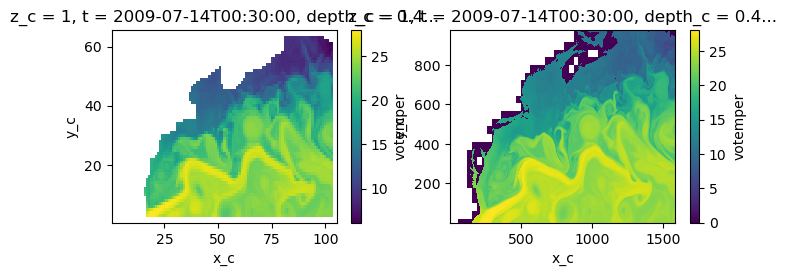

In [450]:
%%time
%%memit
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,2.5))
ds_LR.votemper.isel(z_c=0, t=0).plot(ax=ax[0])
ds.votemper.isel(z_c=0, t=0).plot(ax=ax[1])

# LR metrics

In [453]:
ds_LR

<xarray.Dataset>
Dimensions:       (y_c: 65, x_c: 105, z_c: 107, t: 3, z_l: 107)
Coordinates: (12/13)
  * z_c           (z_c) int64 1 2 3 4 5 6 7 8 ... 101 102 103 104 105 106 107
  * y_c           (y_c) int64 1 2 3 4 5 6 7 8 9 ... 57 58 59 60 61 62 63 64 65
  * x_c           (x_c) int64 1 2 3 4 5 6 7 8 ... 98 99 100 101 102 103 104 105
    llat_cc       (y_c, x_c) float32 dask.array<chunksize=(16, 26), meta=np.ndarray>
    llon_cc       (y_c, x_c) float32 dask.array<chunksize=(16, 26), meta=np.ndarray>
  * t             (t) datetime64[ns] 2009-07-14T00:30:00 ... 2009-07-14T06:30:00
    ...            ...
    e2t           (y_c, x_c) float64 2.153e+04 2.154e+04 ... 1.878e+04 1.88e+04
    tmask         (z_c, y_c, x_c) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    depth_c       (z_c) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
    area_t        (y_c, x_c) float64 dask.array<chunksize=(16, 26), meta=np.ndarray>
    dzt           (z_c) float32 1.078 1.157 1.314 1.472 ... 16.87 16.98 nan
    depth_l       (z_l) float32 -0.05871 1.02 2.177 3.491 ... 960.0 976.9 993.9
Dimensions without coordinates: z_l
Data variables:
    vosaline      (y_c, x_c, z_c, t) float64 dask.array<chunksize=(16, 26, 14, 1), meta=np.ndarray>
    votemper      (y_c, x_c, z_c, t) float64 dask.array<chunksize=(16, 26, 14, 1), meta=np.ndarray>
    dx_p          (y_c, x_c, z_c, t) float64 dask.array<chunksize=(16, 26, 14, 1), meta=np.ndarray>
    dy_p          (y_c, x_c, z_c, t) float64 dask.array<chunksize=(16, 26, 14, 1), meta=np.ndarray>
    vosaline_sqr  (y_c, x_c, z_c, t) float64 dask.array<chunksize=(16, 26, 14, 1), meta=np.ndarray>
    votemper_sqr  (y_c, x_c, z_c, t) float64 dask.array<chunksize=(16, 26, 14, 1), meta=np.ndarray>
    rho           (y_c, x_c, z_c, t) float64 dask.array<chunksize=(16, 26, 14, 1), meta=np.ndarray>

In [481]:
ds_LR.coords['area_t'] = ds_LR['e1t']*ds_LR['e2t']

In [482]:
metrics = {
    ('X',): ['e1t'], # X distances
    ('Y',): ['e2t'], # Y distances
    ('X', 'Y',): ['area_t'] # Areas 
}

In [483]:
grid_LR = xgcm.Grid(ds, metrics=metrics, periodic=False, coords={'X' : {'center' : 'x_c'}, \
                                                              'Y' : {'center' : 'y_c'},
                                                              'Z' : {'center' : 'z_c', 'left' : 'z_l'}})

In [484]:
grid_LR

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   x_c
Y Axis (not periodic, boundary=None):
  * center   y_c
Z Axis (not periodic, boundary=None):
  * center   z_c --> left
  * left     z_l --> center

In [478]:
ds_LR.coords['depth_l'] = xr.DataArray(xgcm.autogenerate.generate_grid_ds(ds_LR, {'Z':'depth_c'}).depth_c_left.values, dims='z_l')

In [479]:
# Calculate vertical distances located on the cellboundary
ds_LR.coords['dzc'] = grid_LR.diff(ds_LR.depth_c, 'Z', boundary='fill', fill_value=np.NaN)
# Calculate vertical distances located on the cellcenter
ds_LR.coords['dzt'] = grid_LR.diff(ds_LR.depth_l, 'Z', boundary='fill', fill_value=np.NaN)

In [505]:
metrics = {
    ('X',): ['e1t'], # X distances
    ('Y',): ['e2t'], # Y distances
    ('Z',): ['dzc', 'dzt'], # Y distances
    ('X', 'Y',): ['area_t'] # Areas 
}
grid_LR = xgcm.Grid(ds_LR, metrics=metrics, periodic=False, coords={'X' : {'center' : 'x_c'}, \
                                                              'Y' : {'center' : 'y_c'},
                                                              'Z' : {'center' : 'z_c', 'left' : 'z_l'}})

In [506]:
grid_LR

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   x_c
Y Axis (not periodic, boundary=None):
  * center   y_c
Z Axis (not periodic, boundary=None):
  * center   z_c --> left
  * left     z_l --> center

# Density vertical profiles

In [507]:
ds_LR['dz_rho'] = grid_LR.derivative(ds_LR.rho, axis='Z', boundary='extend')

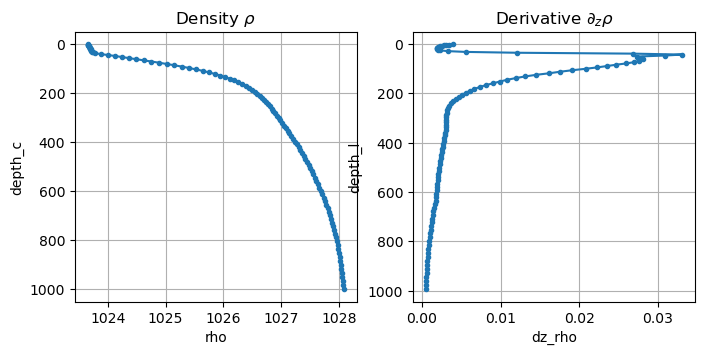

peak memory: 732.14 MiB, increment: 4.55 MiB
CPU times: user 993 ms, sys: 309 ms, total: 1.3 s
Wall time: 52.6 s


In [511]:
%%time
%%memit
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3.5))
ds_LR['rho'].isel(select_time | select_point).plot(ax=ax[0],y='depth_c', marker='.')
ds_LR['dz_rho'].isel(select_time | select_point).plot(ax=ax[1],y='depth_l', marker='.')
ax[0].set(title=r'Density $\rho$')
ax[1].set(title=r'Derivative $\partial_z\rho$')
for axis in ax :
    axis.invert_yaxis(); axis.grid(True)
plt.show()

# Subgrid variance

In [413]:
ds_LR['var_T'] = ds_LR['votemper_sqr'] - ds_LR['votemper']**2
ds_LR['var_S'] = ds_LR['vosaline_sqr'] - ds_LR['vosaline']**2

In [416]:
select_point = {'x_c' : -40, 'y_c' : -40}
select_time = {'t' : 1}
select_area = {'x_c' : slice(60,100), 'y_c' : slice(None,40)}

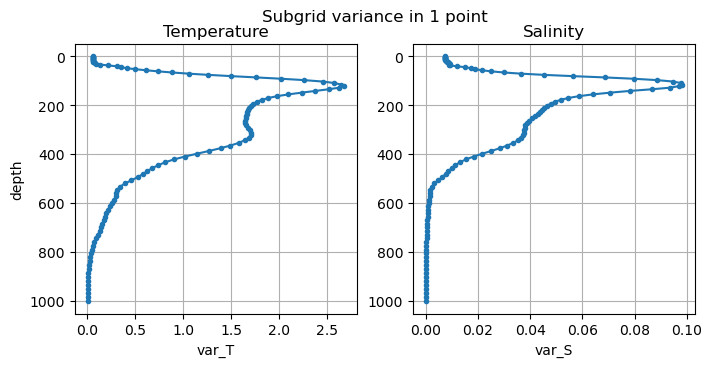

In [502]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3.5))
fig.suptitle('Subgrid variance in 1 point')
ds_LR['var_T'].isel(select_time | select_point).plot(ax=ax[0],y='depth_c', marker='.')
ds_LR['var_S'].isel(select_time | select_point).plot(ax=ax[1],y='depth_c', marker='.')
ax[0].set(title='Temperature')
ax[1].set(title='Salinity')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
ax[0].set(ylabel='depth')
plt.show()

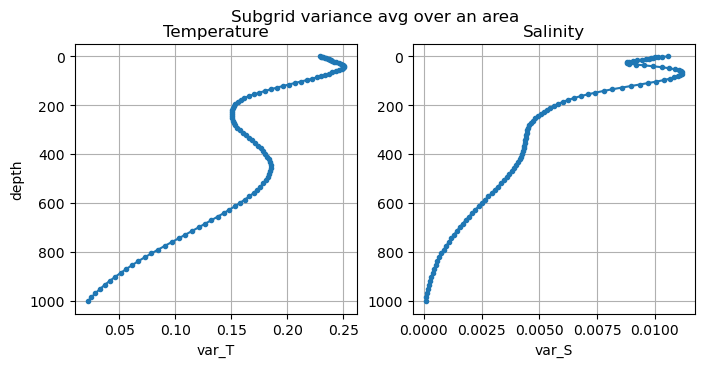

In [503]:
%%time
%%memit
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3.5))
fig.suptitle('Subgrid variance avg over an area')
ds_LR['var_T'].isel(select_area).mean(dim=['x_c', 'y_c', 't']).plot(ax=ax[0],y='depth_c', marker='.')
ds_LR['var_S'].isel(select_area).mean(dim=['x_c', 'y_c', 't']).plot(ax=ax[1],y='depth_c', marker='.')
ax[0].set(title='Temperature')
ax[1].set(title='Salinity')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
ax[0].set(ylabel='depth')
plt.show()